In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

from plato.planets.metrics import PlanetPopulationMetrics
from plato.planets.populations import PopulationModel
from plato.stars import filter_p1_targets, filter_valid_targets
from plato.visualisation import (
    FigureProcessor,
    contour_plot,
    get_earth_marker,
    get_palette,
    set_plot_defaults,
)

In [14]:
set_plot_defaults()

figure_directory = f"../figures/06_planet_population_metrics/"
save = True

In [5]:
LOPS2 = pd.read_csv(f"../data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(f"../data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

p1_sample = filter_p1_targets(fields)

In [6]:
metrics = PlanetPopulationMetrics()

## Recreate NGPPS II Table 7

In [7]:
metric_table = {}

for num_embryos in [10, 20, 50, 100]:
    population_model = PopulationModel(
        fields,
        num_embryos=num_embryos,
        additional_columns=["Population"],
    )

    mock = population_model.create_mock_population(additional_columns=["Population"])

    table = metrics.calculate_metrics(
        mock,
        by_population=True,
        number_of_systems={
            pop: len(fields[fields["Population"] == pop])
            for pop in fields["Population"].unique()
        },
    )
    metric_table[num_embryos] = table

metric_table = (
    pd.concat(metric_table, axis=1)
    .reindex(
        index=pd.MultiIndex.from_product(
            [
                [
                    "Thin Disk",
                    "Thick Disk Candidate",
                    "Thick Disk",
                    "Halo Candidate",
                    "Halo",
                ],
                ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
            ],
        )
    )
    .round(3)
)

In [8]:
metric_table

10                   \
                                 Number of Planets System Fraction   
Thin Disk            Earth                  193127           0.563   
                     Super-Earth            247612           0.690   
                     Neptunian               60512           0.288   
                     Sub-Giant               24713           0.135   
                     Giant                   46449           0.182   
Thick Disk Candidate Earth                   90220           0.553   
                     Super-Earth            118550           0.690   
                     Neptunian               27811           0.279   
                     Sub-Giant               12464           0.143   
                     Giant                   21623           0.178   
Thick Disk           Earth                    9258           0.566   
                     Super-Earth             15891           0.757   
                     Neptunian                2811           0.265   
                     Sub-Giant                1638           0.185   
                     Giant                    1845           0.144   
Halo Candidate       Earth                     367           0.533   
                     Super-Earth              1049           0.885   
                     Neptunian                  71           0.140   
                     Sub-Giant                 133           0.327   
                     Giant                      44           0.071   
Halo                 Earth                     445           0.533   
                     Super-Earth              1358           0.924   
                     Neptunian                  84           0.145   
                     Sub-Giant                 195           0.392   
                     Giant                      34           0.048   

                                                               \
                                 Occurrence Rate Multiplicity   
Thin Disk            Earth                 1.122        1.993   
                     Super-Earth           1.438        2.083   
                     Neptunian             0.351        1.220   
                     Sub-Giant             0.144        1.060   
                     Giant                 0.270        1.480   
Thick Disk Candidate Earth                 1.097        1.984   
                     Super-Earth           1.442        2.090   
                     Neptunian             0.338        1.211   
                     Sub-Giant             0.152        1.060   
                     Giant                 0.263        1.475   
Thick Disk           Earth                 1.074        1.897   
                     Super-Earth           1.843        2.435   
                     Neptunian             0.326        1.229   
                     Sub-Giant             0.190        1.029   
                     Giant                 0.214        1.482   
Halo Candidate       Earth                 0.902        1.691   
                     Super-Earth           2.577        2.914   
                     Neptunian             0.174        1.246   
                     Sub-Giant             0.327        1.000   
                     Giant                 0.108        1.517   
Halo                 Earth                 0.895        1.679   
                     Super-Earth           2.732        2.959   
                     Neptunian             0.169        1.167   
                     Sub-Giant             0.392        1.000   
                     Giant                 0.068        1.417   

                                               20                   \
                                 Number of Planets System Fraction   
Thin Disk            Earth                  352222           0.649   
                     Super-Earth            341345           0.750   
                     Neptunian               64970           0.309   
                     Sub-Giant               20269

In [9]:
# print(metric_table[100].round(2).astype(str).to_latex())

## GET UNCERTAINTIES FOR HALO PLANETS, ALSO METALLICITY CUT

In [9]:
halo_table = defaultdict(dict)

for num_embryos in [10, 20, 50, 100]:
    for metallicity_name, metallicity_cut in {
        "Halo (Without [Fe/H] Cut)": None,
        "Halo (With [Fe/H] Cut)": -0.6,
    }.items():
        halo_population_model = PopulationModel(
            fields[fields["Population"] == "Halo"],
            num_embryos=num_embryos,
            additional_columns=["Population"],
        )

        halo_mocks = [
            halo_population_model.create_mock_population(
                additional_columns=["Population"],
                metallicity_limit=metallicity_cut,
            )
            for _ in range(300)
        ]

        halo_metrics = [
            metrics.calculate_number_of_planets(
                mock,
            )
            for mock in halo_mocks
        ]

        halo_metrics_stats = metrics.calculate_metrics_stats(
            halo_metrics,
            grouping_column="Planet Category",
            format_uncertainties=True,
            round_decimals="ceil",
            to_int=True,
            new_col_name="",
        )

        halo_table[num_embryos][metallicity_name] = halo_metrics_stats

halo_table = pd.concat(
    {key: pd.concat(val, axis=0) for key, val in halo_table.items()},
    axis=1,
)
halo_table.columns = halo_table.columns.droplevel(1)
halo_table = halo_table.reindex(
    ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
    level=1,
)

In [10]:
num_planets = (
    metric_table[:]["Number of Planets"]
    .drop(index=["Thick Disk Candidate", "Halo Candidate", "Halo"], level=0)
    .rename(
        index={
            "Without Limit": "Halo (Without [Fe/H] Cut])",
            "With Limit": "Halo (With [Fe/H] Cut)",
        },
        level=0,
    )
)
num_planets.columns = [10, 20, 50, 100]

halo_table = pd.concat([num_planets, halo_table], axis=0)

In [11]:
halo_table

10                  20   \
Thin Disk                 Earth                    194636              353235   
                          Super-Earth              248280              340098   
                          Neptunian                 60691               64880   
                          Sub-Giant                 24729               20545   
                          Giant                     46151               47463   
Thick Disk                Earth                      9512               17779   
                          Super-Earth               15970               19930   
                          Neptunian                  2736                3499   
                          Sub-Giant                  1707                1181   
                          Giant                      1819                1852   
Halo (Without [Fe/H] Cut) Earth         $448^{+23}_{-23}$   $918^{+35}_{-39}$   
                          Super-Earth  $1347^{+34}_{-32}$  $1361^{+43}_{-40}$   
                          Neptunian      $88^{+10}_{-11}$   $201^{+13}_{-12}$   
                          Sub-Giant     $172^{+11}_{-10}$      $52^{+9}_{-8}$   
                          Giant            $35^{+6}_{-7}$      $36^{+8}_{-6}$   
Halo (With [Fe/H] Cut)    Earth          $87^{+10}_{-10}$   $159^{+17}_{-15}$   
                          Super-Earth   $155^{+13}_{-11}$   $196^{+15}_{-16}$   
                          Neptunian        $24^{+6}_{-4}$      $36^{+6}_{-5}$   
                          Sub-Giant        $20^{+3}_{-5}$      $10^{+5}_{-3}$   
                          Giant            $15^{+5}_{-4}$      $17^{+5}_{-5}$   

                                                      50                  100  
Thin Disk                 Earth                    658741              790839  
                          Super-Earth              536002              659487  
                          Neptunian                 55999               59636  
                          Sub-Giant                 15518               17207  
                          Giant                     43212               45810  
Thick Disk                Earth                     34765               45119  
                          Super-Earth               19808               23974  
                          Neptunian                  1613                1664  
                          Sub-Giant                   434                 491  
                          Giant                      1186                1220  
Halo (Without [Fe/H] Cut) Earth        $1971^{+55}_{-66}$  $2912^{+80}_{-64}$  
                          Super-Earth   $474^{+32}_{-39}$   $549^{+38}_{-35}$  
                          Neptunian        $27^{+6}_{-5}$      $19^{+7}_{-5}$  
                          Sub-Giant         $3^{+2}_{-1}$      $14^{+4}_{-5}$  
                          Giant            $22^{+5}_{-4}$      $24^{+4}_{-5}$  
Halo (With [Fe/H] Cut)    Earth         $282^{+21}_{-23}$   $384^{+24}_{-29}$  
                          Super-Earth   $194^{+24}_{-20}$   $259^{+29}_{-28}$  
                          Neptunian        $27^{+5}_{-5}$      $19^{+6}_{-5}$  
                          Sub-Giant         $4^{+2}_{-2}$      $13^{+5}_{-4}$  
                          Giant            $23^{+4}_{-5}$      $23^{+6}_{-4}$

In [12]:
# print(halo_table.to_latex())

## OCCURENCE RATE PLOT

/tmp/ipykernel_12213/4031828878.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  occurence_rate_barplot = sns.barplot(

/tmp/ipykernel_12213/4031828878.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  occurence_rate_barplot = sns.barplot(



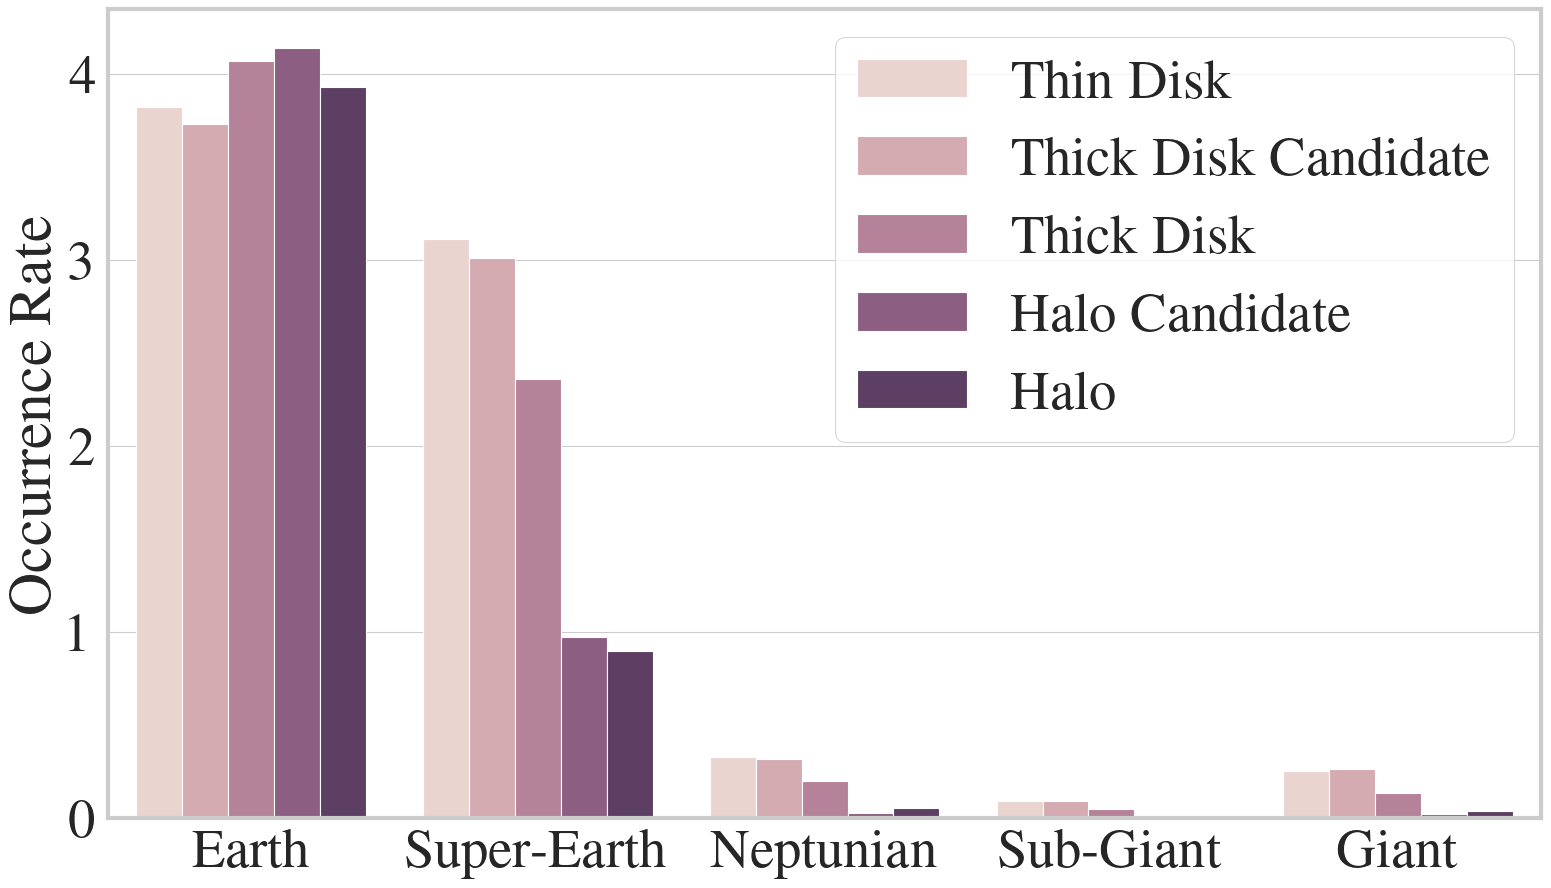

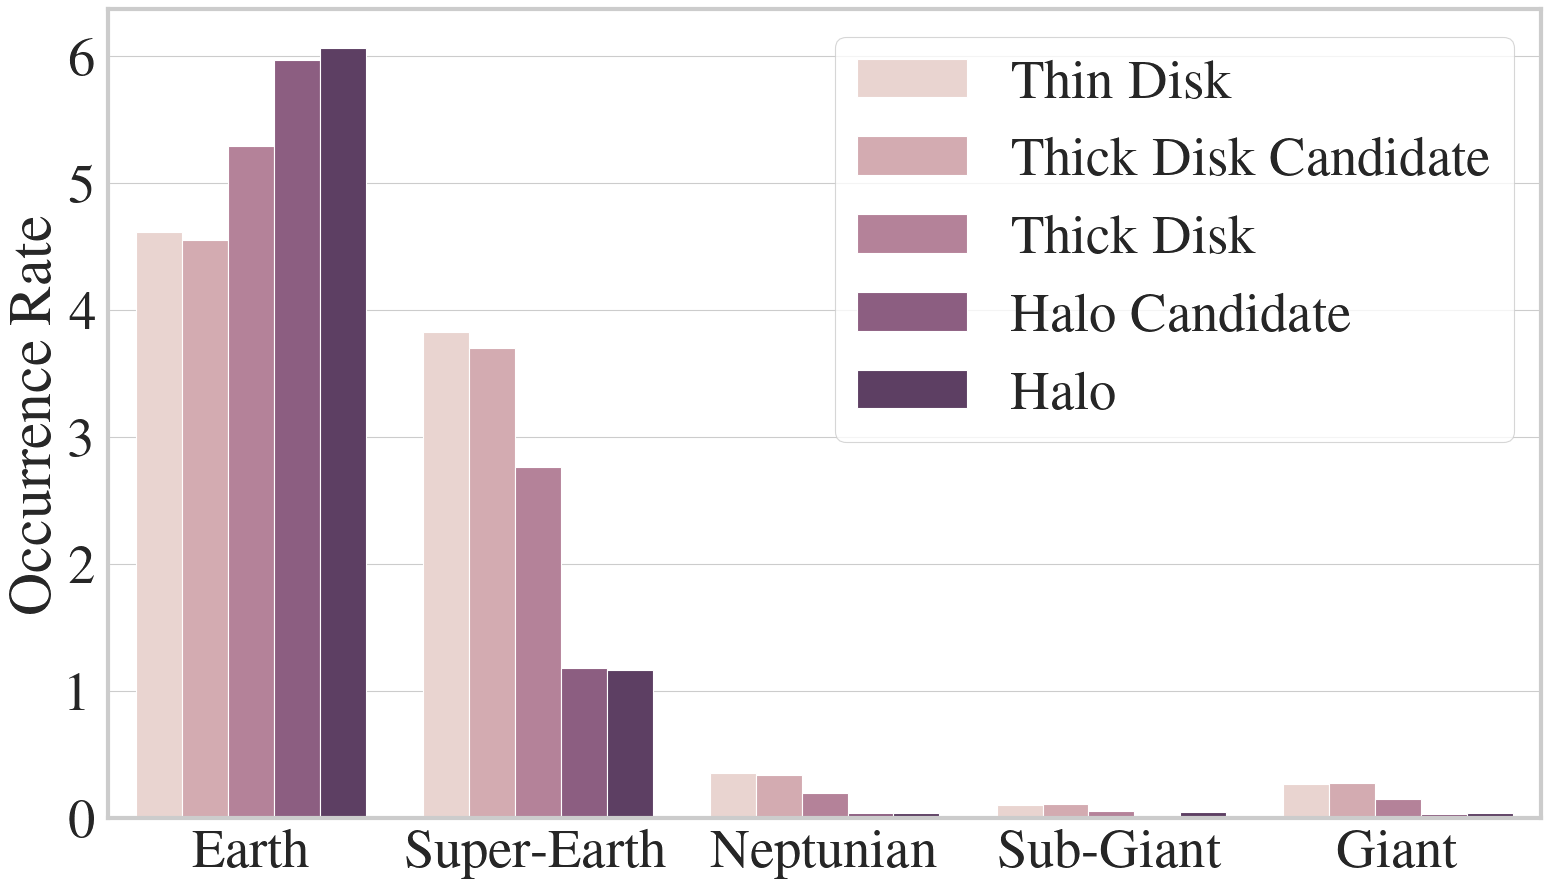

In [39]:
for num_embryos in [10, 100]:
    plt.figure()
    occurence_rates = metric_table[num_embryos]["Occurrence Rate"].reset_index()
    occurence_rates.rename(
        columns={"level_0": "Population", "level_1": "Planet Category"}, inplace=True
    )

    occurence_rate_barplot = sns.barplot(
        data=occurence_rates,
        x="Planet Category",
        y="Occurrence Rate",
        hue="Population",
        # hue_order=components,
        # log=True,
        palette=get_palette(),
    )
    occurence_rate_barplot.set_xlabel("")
    occurence_rate_barplot.legend(title="")

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_N_Embryos={num_embryos}.pdf",
        figure_directory=figure_directory,
        save=save,
    )